In [1]:
# Francisco Dominguez Mateos
# 17/07/2020
#https://www.reddit.com/r/MachineLearning/comments/eumz0l/p_we_rewrote_david_mackays_bayesian_neural/
#https://engineering.papercup.com/posts/bayesian-neural-nets/
#https://colab.research.google.com/github/papercup-open-source/tutorials/blob/master/intro_bnn/Bayesian_neural_networks_Part_1.ipynb#scrollTo=1idsceQZhacG

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import jax
import jax.numpy as np
from jax import random
from jax import jit, grad
from jax import vmap, partial

from IPython.display import HTML
from matplotlib.animation import FuncAnimation
#from google.colab import files

key = random.PRNGKey(0)

In [3]:
#Test if JAX is using CPU or GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [4]:
key, subkey = random.split(key)

x_range = np.linspace(0, 10, 100)
y_range = np.linspace(0, 10, 100)
Zd = np.stack((
    np.expand_dims(x_range, axis=1).repeat(100, axis=1),
    np.expand_dims(y_range, axis=0).repeat(100, axis=0),
    np.ones((100, 100)),
), axis=2)

In [5]:
def plot_fns_and_weights(fns, weights, idx):
  x_range = np.linspace(0, 10, 100)
  y_range = np.linspace(0, 10, 100)
  fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(12, 6))

  # Plot weight values on x1 and x2
  ax2.set(xlim=(-1, 5), ylim=(-1, 5))
  ax2.scatter(weights[:, 0], weights[:, 1])
  ax2.set_xlabel('$w_1$')
  ax2.set_ylabel('$w_2$')

  # Plot the weights values as training continues
  ax3.plot(weights[:, 0])
  ax3.plot(weights[:, 1])
  ax3.plot(weights[:, 2])
  ax3.set_xlabel('Step')
  ax3.set_ylabel('$|w_i|$')

  # Animation
  fig, ax = plt.subplots(figsize=(6, 6))
  plt.close()
  ax.set(xlim=(0, 10), ylim=(0, 10))

  ax.scatter(D1[:, 0], D1[:, 1])
  ax.scatter(D2[:, 0], D2[:, 1])
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')
  ax.set_title("Step: {}".format(0))
  cont = ax.contour(x_range, y_range, fns[0], origin='lower', cmap=cm.viridis, vmin=0, vmax=1)

  def animate(i):
      ax.cla()
      ax.scatter(D1[:, 0], D1[:, 1])
      ax.scatter(D2[:, 0], D2[:, 1])
      ax.set_xlabel('$x_1$')
      ax.set_ylabel('$x_2$')
      ax.set_title("Step: {}".format(idx[i]))
      ax.contour(x_range, y_range, fns[i], vmin=0, vmax=1)

  anim = FuncAnimation(fig, animate, interval=200, frames=len(idx))
  return anim

[(0.0, 10.0), (0.0, 10.0)]

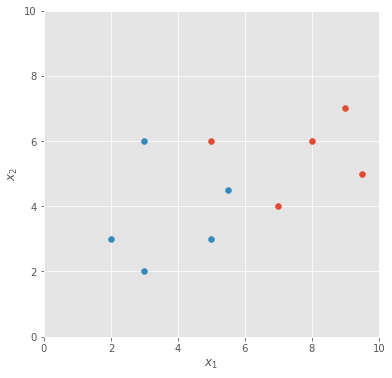

In [6]:
D1 = np.array([
    (7, 4),
    (5, 6),
    (8, 6),
    (9.5, 5),
    (9, 7),
])
D2 = np.array([
    (2, 3),
    (3, 2),
    (3, 6),
    (5.5, 4.5),
    (5, 3),
])

D_tmp = np.concatenate((D1, D2), axis=0)
D = np.concatenate((D_tmp, np.ones((10, 1))), axis=1)
t = np.concatenate((np.array([1.]*5), np.array([0.]*5)))

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(D1[:, 0], D1[:, 1])
ax.scatter(D2[:, 0], D2[:, 1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set(xlim=(0, 10), ylim=(0, 10))

In [7]:
@jit
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

@jit
def bce_loss(W, D, t):
    a = np.dot(D, W)
    y = sigmoid(a)
    error = (- t * np.log(y) - (1 - t) * np.log(1 - y)).sum()

    return error

@jit
def regularization_loss(W):
   return 0.5 * (W.dot(W)).sum()

In [8]:
eta = 0.02
W = random.normal(key, (3,)) * 0.25
idx = []
fns = []
weights = []

@jit
def step(W, D, t, eta=0.02):
  dW = grad(bce_loss)(W, D, t)
  W = W - eta * dW

  return W

for k in range(20001):
  # Calculate and save for contour lines
  if (k % 1000 == 0) or (k <= 1000 and k % 100 == 0):
    idx.append(k)
    a = np.dot(Zd, W)
    y = sigmoid(a)
    fns.append(y)

  W = step(W, D, t, eta=eta)

  weights.append(W)

fns = np.array(fns)
weights = np.array(weights)

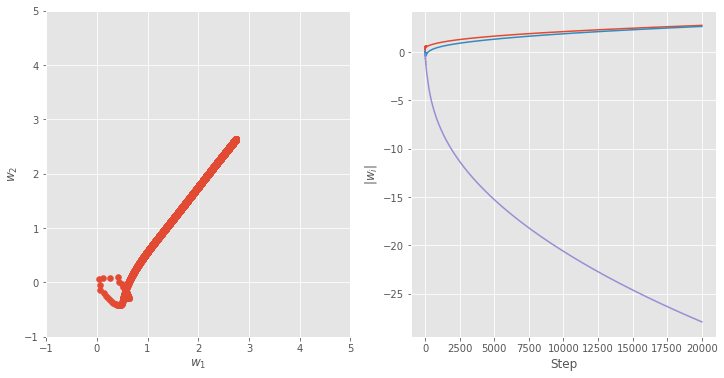

In [9]:
anim = plot_fns_and_weights(fns, weights, idx)
HTML(anim.to_html5_video())

In [10]:
eta = 0.02
alpha = 0.01
W = random.normal(key, (3,)) * 0.25
idx = []
fns = []
weights = []

@jit
def loss(W, D, t, alpha):
  return bce_loss(W, D, t) + alpha * regularization_loss(W)

@jit
def step(W, D, t, eta=0.02, alpha=0.01):
  dW = grad(loss)(W, D, t, alpha)
  W = W - eta * dW

  return W

for k in range(10001):
  # Calculate and save for contour lines
  if (k % 1000 == 0) or (k <= 1000 and k % 100 == 0):
    idx.append(k)
    a = np.dot(Zd, W)
    y = sigmoid(a)
    fns.append(y)

  W = step(W, D, t, eta=eta, alpha=alpha)

  weights.append(W)

fns = np.array(fns)
weights = np.array(weights)

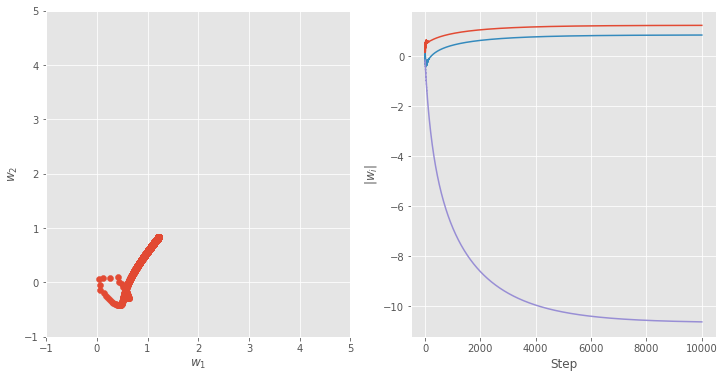

In [11]:
anim = plot_fns_and_weights(fns, weights, idx)
HTML(anim.to_html5_video())

# Langevin Monte Carlo method - MCMC Hammer

In [12]:
@jit
def loss(W, D, t, alpha):
  return bce_loss(W, D, t) + alpha * regularization_loss(W)

@jit
def step(W, dW, M, k1):
  #get a random perturbation vector
  p = random.normal(k1, (3,))
  #this value seem to be used in Metropolis-Hastings sampling
  H = (p ** 2).sum() / 2 + M
  
  # For Hamiltonian Monte Carlo, run the following 4 lines for tau iterations, 
  # tau > 1
  #change p in it dW direction
  p = p - epsilon / 2 * dW
  #compute a new W from perturbation p and old W
  new_W = W + epsilon * p
  #compute gradient at new W
  new_dW = grad(loss)(new_W, D, t, alpha=alpha)
  #perturbe p by the new gradient
  p = p - epsilon / 2 * new_dW

  #compute likelihood function P(D|new_W) just the loss
  new_M = loss(new_W, D, t, alpha=alpha)
  #the H for new value
  new_H = (p ** 2).sum() / 2 + new_M

  #difference in H
  dH = new_H - H

  return dH, new_W, new_dW, new_M, k1

eta = 0.02
epsilon = np.sqrt(2 * eta)
alpha = 0.01
W = random.normal(key, (3,)) * 0.25
idx = []
fns = []
weights = []
k0 = 2000

accepts = 0
M = loss(W, D, t, alpha=alpha)
dW = - grad(loss)(W, D, t, alpha=alpha)

k1, k2 = random.split(key)

for k in range(10001):
  k1, k2 = random.split(k1)
  dH, new_W, new_dW, new_M, k1 = step(W, dW, M, k1)

  #Metropolis-Hastings sample selection
  if (dH < 0) or (random.uniform(k2) < np.exp(-dH)):
    accepts += 1
    W = new_W
    M = new_M
    dW = new_dW

  if (k > k0 and k % 100 == 0):
    weights.append(W)
    a = np.dot(Zd, W)
    y = sigmoid(a)
    fns.append(y)
    idx.append(k)

fns = np.array(fns)
weights = np.array(weights)

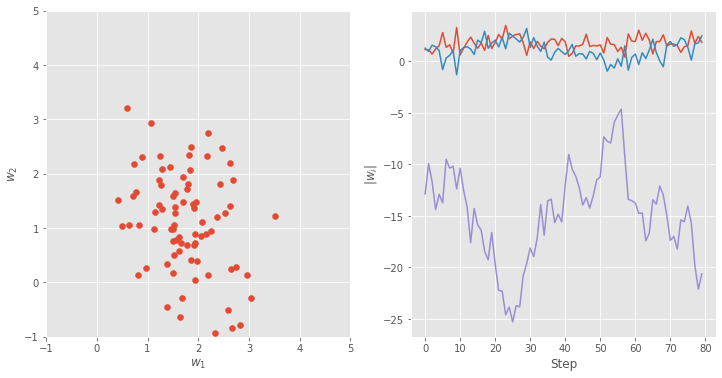

In [13]:
anim = plot_fns_and_weights(fns, weights, idx)
HTML(anim.to_html5_video())

Text(0, 0.5, '$x_2$')

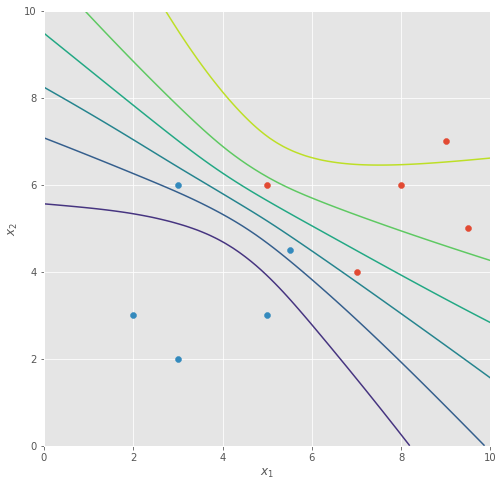

In [14]:
Z = fns.mean(axis=0)
plt.figure(figsize=(8, 8))
_ = plt.contour(x_range, y_range, Z, origin='lower',
                cmap=cm.viridis, vmin=0, vmax=1)
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

Text(0, 0.5, '$x_2$')

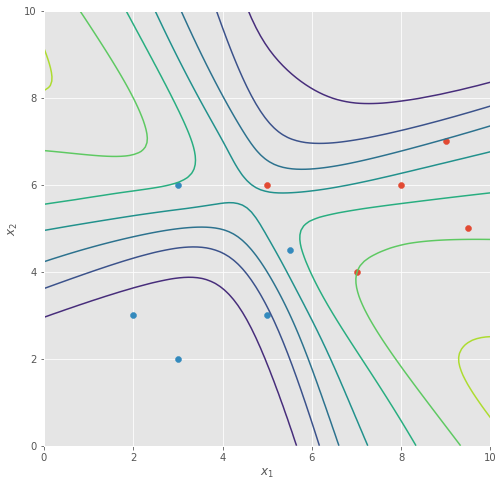

In [15]:
Z = fns.std(axis=0)
plt.figure(figsize=(8, 8))
_ = plt.contour(x_range, y_range, Z, origin='lower',
                cmap=cm.viridis)
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

# Laplace's method - Tame your expectations

The Laplace's method approach distribution over weights as a gaussian where the mean is just the traditional MAP and the variance is the inverse of the hessian in the MAP point.

$$
\begin{aligned}
          P(\mathbf{w} | D) &\approx Q(\mathbf{w} | \theta) \\
     Q(\mathbf{w} | \theta) &= \text{Normal}(\mathbf{w}_{\text{MAP}}, H^{-1}) \\
\text{where} \quad \theta &= \{ \mathbf{w}_{\text{MAP}}, H^{-1} \}
\end{aligned}
$$

The problem with this approach is that variance is full and O(n^2) where n is the number os weights, then it doesn't work with big neural networks.

In [16]:
eta = 0.02
alpha = 0.01
W = random.normal(key, (3,)) * 0.25
idx = []
fns = []
weights = []


@jit
def loss(W, D, t, alpha):
  return bce_loss(W, D, t) + alpha * regularization_loss(W)


@jit
def step(W, D, t, eta=0.02, alpha=0.01):
  dW = grad(loss)(W, D, t, alpha=alpha)
  W = W - eta * dW

  return W


for k in range(10001):
  W = step(W, D, t, eta=eta, alpha=alpha)

W_MAP = W

In [17]:
from jax import jacfwd, jacrev  # forward and reverse-mode

def hessian(fun):
  return jit(jacfwd(jacrev(fun)))  # jit!

hess = hessian(loss)(W_MAP, D, t, 0.01)
Sigma = np.linalg.inv(hess)

In [18]:
print(Sigma)

[[ 0.6003367   0.09462474 -3.6178284 ]
 [ 0.09462633  0.7918662  -4.2730007 ]
 [-3.6178362  -4.272992   40.549576  ]]


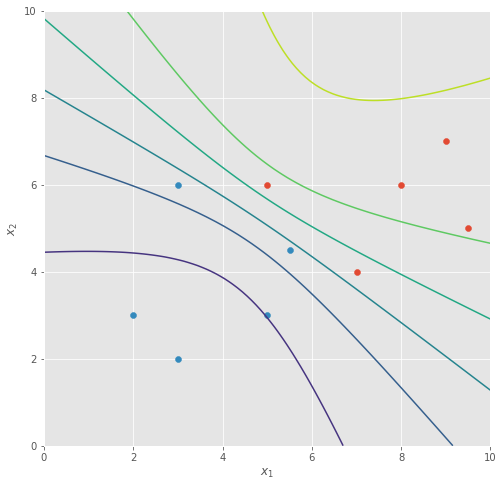

In [19]:
# Approximation method for inference
kappa = (Zd.dot(Sigma) * Zd).sum(2)
kappa = 1 / (1 + np.pi * kappa / 8) ** 0.5

a = np.dot(Zd, W_MAP) * kappa
Z = sigmoid(a)


plt.figure(figsize=(8, 8))
_ = plt.contour(x_range, y_range, Z, origin='lower',
                cmap=cm.viridis, vmin=0, vmax=1)
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
_ = plt.xlabel('$x_1$')
_ = plt.ylabel('$x_2$')

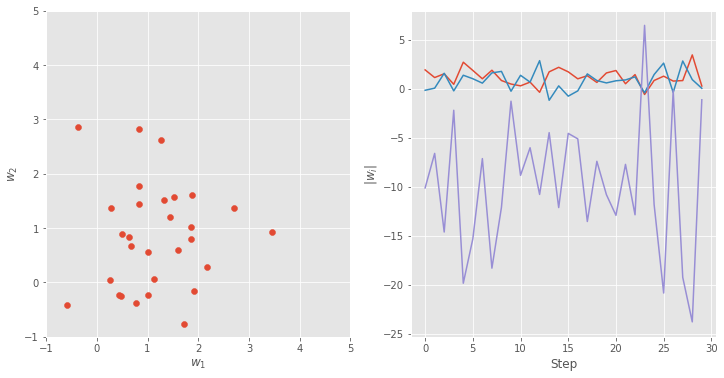

In [20]:
# Monte Carlo method for inference
K_inference = 30
sigma = np.linalg.cholesky(Sigma)

k1, k2 = random.split(key)
eps = random.normal(k1, (K_inference, 3))

W = W_MAP + vmap(sigma.dot)(eps)

partial_func = partial(lambda e: np.dot(Zd, e))

a = vmap(partial_func)(W)
fns = sigmoid(a)

anim = plot_fns_and_weights(fns, W, range(len(fns)))
HTML(anim.to_html5_video())

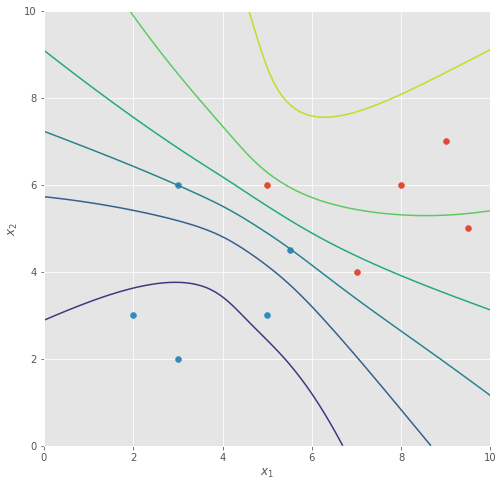

In [21]:
Z = fns.mean(0)
plt.figure(figsize=(8, 8))
_ = plt.contour(x_range, y_range, Z, origin='lower',
                cmap=cm.viridis, vmin=0, vmax=1)
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
_ = plt.xlabel('$x_1$')
_ = plt.ylabel('$x_2$')

Text(0, 0.5, '$x_2$')

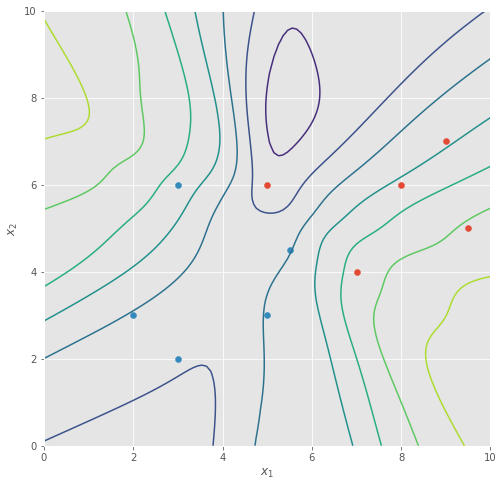

In [22]:
Z = fns.std(axis=0)
plt.figure(figsize=(8, 8))
_ = plt.contour(x_range, y_range, Z, origin='lower',
                cmap=cm.viridis)
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

# Variational Free Energy method - VI-ing for attention
$$
\begin{aligned}
\text{KL}(Q \, || \, P) = \mathbb{E}_{Q} \bigg[ \log\bigg( \frac{Q}{P} \bigg) \bigg]
\end{aligned}
$$

$$
\begin{aligned}
\text{KL}(Q(\mathbf{w} | \theta) \, || \, P(\mathbf{w} | D)) &= \int Q(\mathbf{w} | \theta) \log \bigg( \frac{Q(\mathbf{w} | \theta)}{P(\mathbf{w} | D)} \bigg) d\mathbf{w} 
\end{aligned}
$$

We are considering that:
$$
P(\mathbf{w} | D)=\frac{e^{M(\mathbf{w})}}{Z}=\frac{e^{M(\mathbf{w})}}{\int e^{M(\mathbf{w})}d\mathbf{w} }
$$
As we can imagine Z is imposible to compute, but we can make aproximations
$$
\begin{aligned}
&= \int Q(\mathbf{w} | \theta) \log \bigg( \frac{Q(\mathbf{w} | \theta)}{ e^{M(\mathbf{w})} } \bigg) d\mathbf{w} + \log(Z) \\
&= \underbrace{ \mathbb{E}_{Q(\mathbf{w} | \theta)} [\log(Q(\mathbf{w} | \theta))] - \int Q(\mathbf{w} | \theta) M(\mathbf{w}) \, d\mathbf{w} }_\text{Variational Free Energy/Evidence Lower Bound} + \log(Z)
\end{aligned}
$$
Given that:
$$
P(D | \mathbf{w})=\frac{P(\mathbf{w} | D)P(D)}{P(\mathbf{w})}
$$
and since P(D) is constant we can compute ELBO.
$$
\text{ELBO} = \text{KL}(Q(\mathbf{w} | \theta) \, || \, P(\mathbf{w})) - \mathbb{E}_{Q(\mathbf{w} | \theta)} [ \log(P(D | \mathbf{w})) ]
$$

In [23]:
eta = 0.02
alpha = 0.01
K = 10 # Number of Monte Carlo samples

k1, k2 = random.split(key)
theta = random.normal(k1, (6,))
idx = []
fns = []
weights = []


@jit
def map_loss(W, D, t, alpha):
  return bce_loss(W, D, t) + alpha * regularization_loss(W)


@jit
def vi_loss(theta, eps, D, t, alpha):
  mu = theta[:3]
  log_sigma = theta[3:]
  sigma = np.exp(log_sigma)
  W = mu + eps * sigma
  errors = map_loss(W, D, t, alpha)

  return errors

@jit
def KL_loss(theta):
  log_sigma = theta[3:]
  return - (log_sigma).sum()

@jit
def step(theta, D, t, k1, eta=0.02, alpha=0.01):
  eps = random.normal(k1, (K, 3))

  partial_loss_func = partial(lambda e: grad(vi_loss)(theta, e, D=D, t=t, alpha=alpha))

  dtheta = np.nanmean(vmap(partial_loss_func)(eps), 0)

  d_KL_theta = grad(KL_loss)(theta)

  theta = theta - eta * (dtheta + d_KL_theta)

  return theta

for k in range(10001):
  k1, k2 = random.split(k1)

  theta = step(theta, D, t, k1, eta=eta, alpha=alpha)

In [24]:
print(theta)

[  1.7252898    0.95954394 -14.1275215   -1.3678851   -1.3724306
   0.29003334]


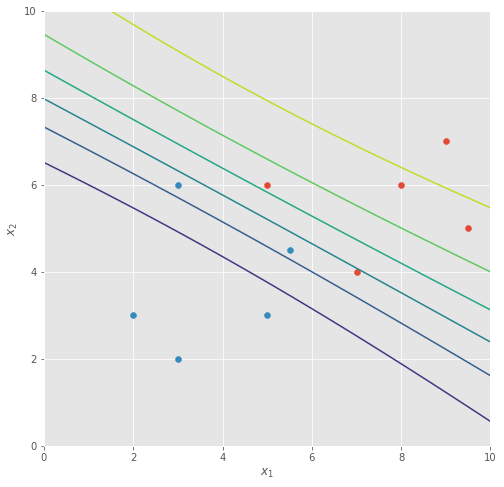

In [25]:
# Approximation method
mu = theta[:3]
log_sigma = theta[3:]
Sigma = np.diag(np.exp(log_sigma * 2))

kappa = (Zd.dot(Sigma) * Zd).sum(2)
kappa = 1 / (1 + np.pi * kappa / 8) ** 0.5

a = np.dot(Zd, mu) * kappa
Z = sigmoid(a)

plt.figure(figsize=(8, 8))
_ = plt.contour(x_range, y_range, Z, origin='lower',
                cmap=cm.viridis, vmin=0, vmax=1)
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
_ = plt.xlabel('$x_1$')
_ = plt.ylabel('$x_2$')

In [26]:
print(Sigma)

[[0.06484404 0.         0.        ]
 [0.         0.06425722 0.        ]
 [0.         0.         1.7861575 ]]


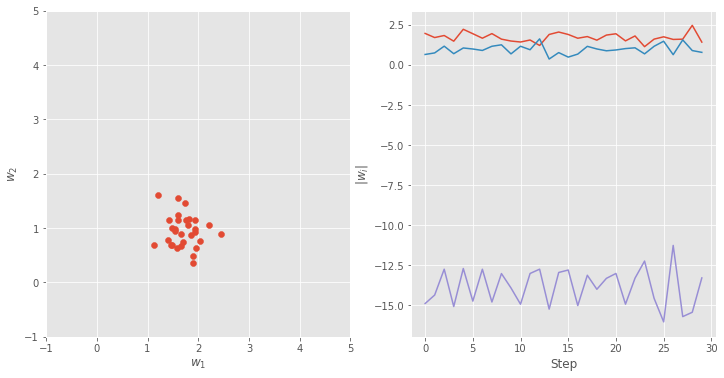

In [27]:
# Monte Carlo method for inference
K_inference = 30
sigma = np.exp(log_sigma)

k1, k2 = random.split(key)
eps = random.normal(k1, (K_inference, 3))

partial_func = partial(lambda e: np.multiply(sigma, e))
W = mu + vmap(partial_func)(eps)

partial_func = partial(lambda e: np.dot(Zd, e))

a = vmap(partial_func)(W)
fns = sigmoid(a)

anim = plot_fns_and_weights(fns, W, range(len(fns)))
HTML(anim.to_html5_video())

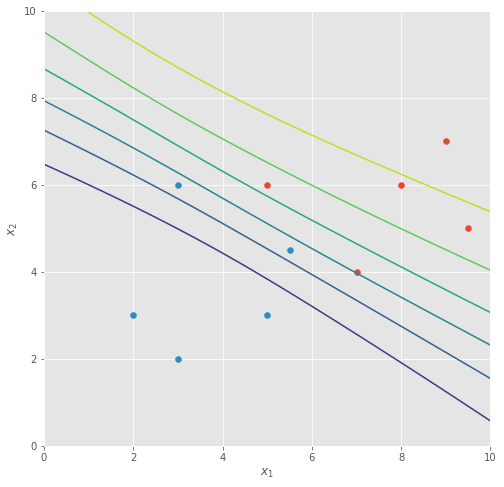

In [28]:
Z = fns.mean(0)
plt.figure(figsize=(8, 8))
_ = plt.contour(x_range, y_range, Z, origin='lower',
                cmap=cm.viridis, vmin=0, vmax=1)
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
_ = plt.xlabel('$x_1$')
_ = plt.ylabel('$x_2$')

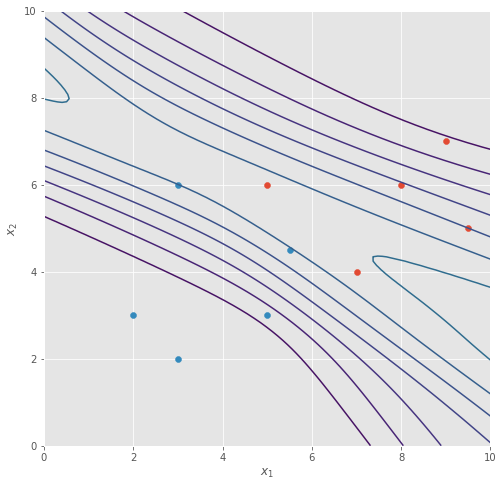

In [29]:
Z_std = fns.std(axis=0)
plt.figure(figsize=(8, 8))
_ = plt.contour(x_range, y_range, Z_std, origin='lower',
                cmap=cm.viridis, vmin=0, vmax=1)
plt.scatter(D1[:, 0], D1[:, 1])
plt.scatter(D2[:, 0], D2[:, 1])
_ = plt.xlabel('$x_1$')
_ = plt.ylabel('$x_2$')